Part 1: Extracting data from the file names of each image.

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torch.optim
import torch.nn.functional as F
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torchsummary import summary
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
# create dataset for pandas set with data, this assumes the data is in 1 folder
current_dir = os.getcwd()
root_dir = os.path.join(current_dir, "input")
image_paths = [] # the lists for the labels
vehicle_types = []
vehicle_colors = []
vehicle_subtypes = []
arrimg = []
vt_encoder = LabelEncoder() # tensors dont like strings. we need to encode them
vst_encoder = LabelEncoder()
vc_encoder = LabelEncoder()

for filename in os.listdir(root_dir): # loop to get all the labels from pics
    if filename.endswith('.png'):
        parts = filename.split('_') # i saw the names seperate the features using a _
        vehicle_type, vehicle_subtype = parts[3].split('.')[0], parts[3].split('.')[1] # format is x_x_x_TYPE.SUBTYPE_COLOR_x...
        vehicle_color = parts[4]

        image_path = os.path.join(root_dir, filename) # merge path and name
        img = (Image.open(image_path))
        arrimg.append(np.asarray(img)) # attach array of image

        vehicle_types.append(vehicle_type)
        vehicle_subtypes.append(vehicle_subtype)
        vehicle_colors.append(vehicle_color)

df = pd.DataFrame({ # make dataframe
    'image': arrimg,
    'vehicle_type': vehicle_types,
    'vehicle_subtype': vehicle_subtypes,
    'vehicle_color': vehicle_colors})

df['vehicle_type'] = vt_encoder.fit_transform(df['vehicle_type']) # encode labels and apply to dataframe
df['vehicle_subtype'] = vst_encoder.fit_transform(df['vehicle_subtype'])
df['vehicle_color'] = vc_encoder.fit_transform(df['vehicle_color'])

Part 2: We have to make sure the data can be trained on torch so we need to convert to torchtensor, we might also need to encode the data but we will get to that when we get the data. Were gonna use dataloader and idk a batch size of 12-64 we can choose when we see how much samples we got, heres where we would split the data too.

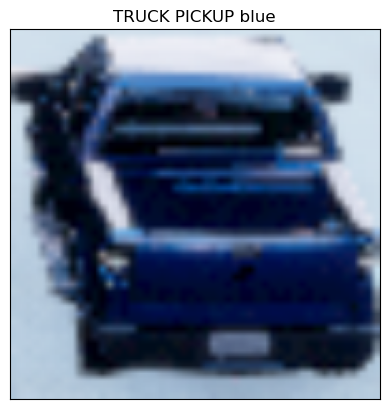

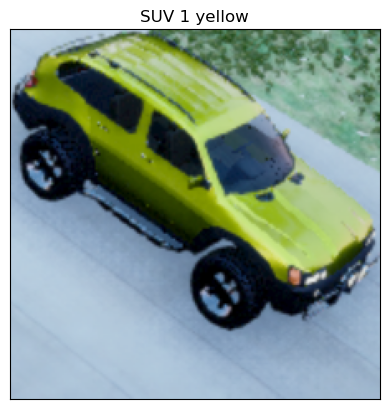

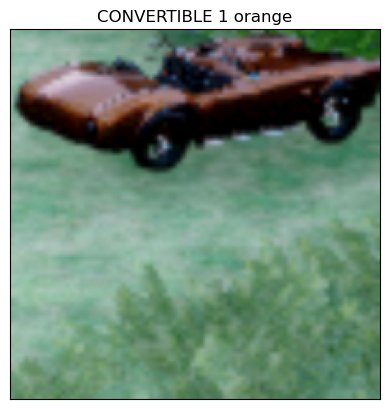

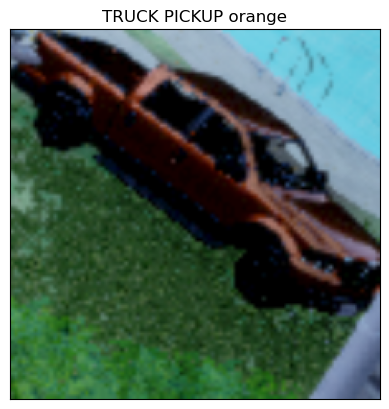

In [ ]:
# we need to manually create our dataset, most of this is in the same format as the Torch docs
class MakeDataset(Dataset):
    def __init__(self, image, vehicle_type, vehicle_subtype, vehicle_color, transform=None):
        self.image = image
        self.vehicle_type = vehicle_type
        self.vehicle_subtype = vehicle_subtype
        self.vehicle_color = vehicle_color
        self.transform = transform

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        image = self.image[idx]
        vehicle_type = self.vehicle_type[idx]
        vehicle_subtype = self.vehicle_subtype[idx]
        vehicle_color = self.vehicle_color[idx]

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        # convert labels to tensor format
        vehicle_type_label = torch.tensor(vehicle_type, dtype=torch.long)
        vehicle_subtype_label = torch.tensor(vehicle_subtype, dtype=torch.long)
        vehicle_color_label = torch.tensor(vehicle_color, dtype=torch.long)

        return image, (vehicle_type_label, vehicle_subtype_label, vehicle_color_label)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # random crop and resize to 224x224 for consistancy
    transforms.RandomRotation(15),  # random rotation of 15 degrees
    transforms.ToTensor(),  # convert to torch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalize
])

# our testing and validation sets shouldnt have data augmentations
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# split the data into 60/20/20 (train/val/test)
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)

# sklearn automatically shuffles data, we need reorganize the dataframe
train_df = train_df.reset_index(drop=True)
temp_df = temp_df.reset_index(drop=True)

# create the dataset with transformations applied and create dataloader for model
dataset1 = MakeDataset(image=train_df.image, vehicle_type=train_df.vehicle_type, vehicle_subtype=train_df.vehicle_subtype, vehicle_color=train_df.vehicle_color, transform=train_transform)
datasettemp = MakeDataset(image=temp_df.image, vehicle_type=temp_df.vehicle_type, vehicle_subtype=temp_df.vehicle_subtype, vehicle_color=temp_df.vehicle_color, transform=val_test_transform)
dataset2, dataset3 = torch.utils.data.random_split(datasettemp, [0.5, 0.5])

dataloaded = DataLoader(dataset1, batch_size=24, shuffle=True)
dataloaded2 = DataLoader(dataset2, batch_size=24, shuffle=False)
dataloaded3 = DataLoader(dataset3, batch_size=24, shuffle=False)

def imshow(img, types, stype, col):
    # denormalize the image
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)  # clamp to [0, 1] range becuase of a warning
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f'{types} {stype} {col}')
    plt.xticks([])
    plt.yticks([])
    plt.show()

# print 5 images after transformations
images, labels = next(iter(dataloaded2))
labels = np.array(labels)
ldecode = []
ldecode.append((vt_encoder.inverse_transform(labels[0]), vst_encoder.inverse_transform(labels[1]), vc_encoder.inverse_transform(labels[2])))

for i in range(4):
    imshow(torchvision.utils.make_grid(images[i]), ldecode[0][0][i], ldecode[0][1][i], ldecode[0][2][i])

Part 3: Since we are using an already created model we can download it here, we need to change it to work with our data.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # cpu training is slow, use GPU if available
weights = models.ResNet50_Weights.DEFAULT # grab resnet weights as base
model = models.resnet50(weights=weights)
num_ftrs = model.fc.in_features # get inputs from final layer

model.fc = nn.Sequential( # transfer learning begins, uses resnets weight's and replaces the output layer with our layers
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(), # RELU works best for this model
    nn.Dropout(0.3), # can be tweaked later
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, len(vt_encoder.classes_) + len(vst_encoder.classes_) + len(vc_encoder.classes_)) # final layer goes to our total features (23)
)
_ = model.to(device) # move to GPU

#summary(model, input_size=(3, 244, 244))

Part 4: Training should begin here and/or we create our class for pytorch, this is where the customization we can do on the next part of the project is.

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
# these hyperparameters can be tweaked next time but we believe Adam is the best optimizer, lr or weight decay can be changed
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-5)

best_val_loss = float('inf')
best_model_state = None

train_losses = []
val_losses = []
train_color_accuracy = []
train_type_accuracy = []
train_stype_accuracy = []
val_color_accuracies = []
val_type_accuracies = []
val_stype_accuracies = []
train_accuracies = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs): # begin training
    model.train()
    running_loss = 0.0

    correct_vehicle_type = 0
    correct_vehicle_stype = 0
    correct_vehicle_color = 0
    total = 0

    for i, (inputs, labels) in enumerate(dataloaded): # extract our data from dataset
        inputs = inputs.to(device) # move the data to GPU
        vehicle_type_labels = labels[0].to(device)
        vehicle_stype_labels = labels[1].to(device)
        vehicle_color_labels = labels[2].to(device)

        # Forward pass
        outputs = model(inputs) # send images to model
        vehicle_type_preds = outputs[:, :len(vt_encoder.classes_)] # 23 different classes, 0-5 are the Types
        vehicle_stype_preds = outputs[:, len(vt_encoder.classes_):len(vt_encoder.classes_) + len(vst_encoder.classes_)] # 6-13 are the Subtypes
        vehicle_color_preds = outputs[:, len(vt_encoder.classes_)+len(vst_encoder.classes_):] # 14-23 are the Colors

        # Compute the losses
        loss_vehicle_type = criterion(vehicle_type_preds, vehicle_type_labels) # send true and predicted values to loss function
        loss_vehicle_stype = criterion(vehicle_stype_preds, vehicle_stype_labels)
        loss_vehicle_color = criterion(vehicle_color_preds, vehicle_color_labels)

        # Total loss
        loss = loss_vehicle_type + loss_vehicle_color + loss_vehicle_stype

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Used for training loss/accuracy
        running_loss += loss.item()
        correct_vehicle_type += (vehicle_type_preds.argmax(dim=1) == vehicle_type_labels).sum().item()
        correct_vehicle_stype += (vehicle_stype_preds.argmax(dim=1) == vehicle_stype_labels).sum().item()
        correct_vehicle_color += (vehicle_color_preds.argmax(dim=1) == vehicle_color_labels).sum().item()
        total += vehicle_type_labels.size(0)

    train_loss = running_loss / len(dataloaded)
    train_losses.append(train_loss)
    train_color_accuracy = (correct_vehicle_color / total) * 100
    train_type_accuracy = (correct_vehicle_type / total) * 100
    train_stype_accuracy = (correct_vehicle_stype / total) * 100
    train_accuracy = (correct_vehicle_type / total + correct_vehicle_stype / total + correct_vehicle_color / total) / 3 * 100
    train_accuracies.append(train_accuracy)

    model.eval()  # puts the model into evaluation mode
    # this part checks for validation lost/accuracy
    val_loss = 0.0
    correct_vehicle_type = 0
    correct_vehicle_stype = 0
    correct_vehicle_color = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloaded2:
            vehicle_type_labels = labels[0].to(device)
            vehicle_stype_labels = labels[1].to(device)
            vehicle_color_labels = labels[2].to(device)
            inputs = inputs.to(device)

            outputs = model(inputs)
            vehicle_type_preds = outputs[:, :len(vt_encoder.classes_)]
            vehicle_stype_preds = outputs[:, len(vt_encoder.classes_):len(vt_encoder.classes_) + len(vst_encoder.classes_)]
            vehicle_color_preds = outputs[:, len(vt_encoder.classes_)+len(vst_encoder.classes_):]

            loss_vehicle_type = criterion(vehicle_type_preds, vehicle_type_labels)
            loss_vehicle_stype = criterion(vehicle_stype_preds, vehicle_stype_labels)
            loss_vehicle_color = criterion(vehicle_color_preds, vehicle_color_labels)
            loss = loss_vehicle_type + loss_vehicle_color + loss_vehicle_stype

            val_loss += loss.item()
            correct_vehicle_type += (vehicle_type_preds.argmax(dim=1) == vehicle_type_labels).sum().item()
            correct_vehicle_stype += (vehicle_stype_preds.argmax(dim=1) == vehicle_stype_labels).sum().item()
            correct_vehicle_color += (vehicle_color_preds.argmax(dim=1) == vehicle_color_labels).sum().item()
            total += vehicle_type_labels.size(0)

    val_loss /= len(dataloaded2)
    val_losses.append(val_loss)
    val_color_accuracy = (correct_vehicle_color / total) * 100
    val_type_accuracy = (correct_vehicle_type / total) * 100
    val_stype_accuracy = (correct_vehicle_stype / total) * 100
    val_accuracy = (correct_vehicle_type / total + correct_vehicle_stype / total + correct_vehicle_color / total) / 3 * 100
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}]\nTrain Loss: {train_loss:.4f}, Train Type Accuracy: {train_type_accuracy:.2f}%, Train Subtype Accuracy: {train_stype_accuracy:.2f}%, Train Color Accuracy: {train_color_accuracy:.2f}%\nVal Loss: {val_loss:.4f}, Val Type Accuracy: {val_type_accuracy:.2f}%, Val Subtype Accuracy: {val_stype_accuracy:.2f}%, Val Color Accuracy: {val_color_accuracy:.2f}%\n')

    # keeps the best model based on the lowest validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

#torch.save(best_model_state, 'best_model.pth')
print("Best model had a validation loss of: {:.4f}".format(best_val_loss))

Epoch [1/10]
Train Loss: 2.7457, Train Type Accuracy: 65.73%, Train Subtype Accuracy: 49.84%, Train Color Accuracy: 88.57%
Val Loss: 3.3220, Val Type Accuracy: 62.19%, Val Subtype Accuracy: 49.68%, Val Color Accuracy: 91.78%

Epoch [2/10]
Train Loss: 1.4457, Train Type Accuracy: 81.75%, Train Subtype Accuracy: 70.69%, Train Color Accuracy: 96.79%
Val Loss: 1.2101, Val Type Accuracy: 83.33%, Val Subtype Accuracy: 78.15%, Val Color Accuracy: 98.18%

Epoch [3/10]
Train Loss: 1.0377, Train Type Accuracy: 86.34%, Train Subtype Accuracy: 80.69%, Train Color Accuracy: 97.20%
Val Loss: 0.7845, Val Type Accuracy: 88.13%, Val Subtype Accuracy: 86.34%, Val Color Accuracy: 98.47%

Epoch [4/10]
Train Loss: 0.7828, Train Type Accuracy: 89.94%, Train Subtype Accuracy: 85.51%, Train Color Accuracy: 97.74%
Val Loss: 0.9561, Val Type Accuracy: 85.34%, Val Subtype Accuracy: 86.97%, Val Color Accuracy: 98.96%

Epoch [5/10]
Train Loss: 0.6714, Train Type Accuracy: 91.23%, Train Subtype Accuracy: 87.32%, Tr

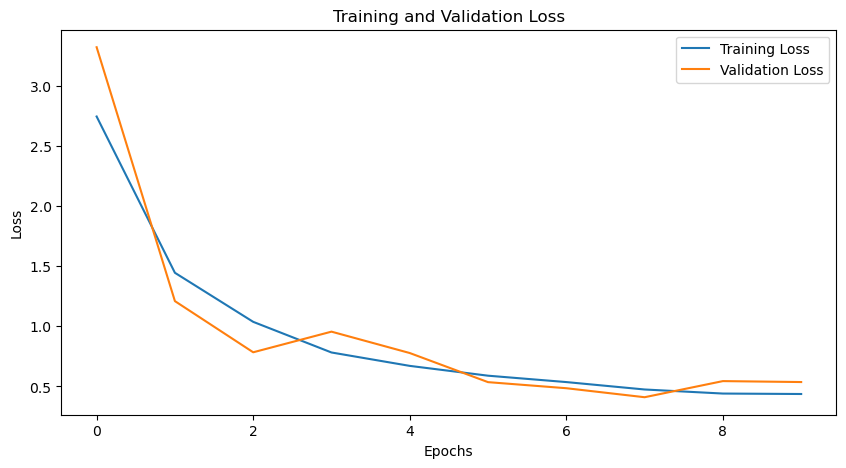

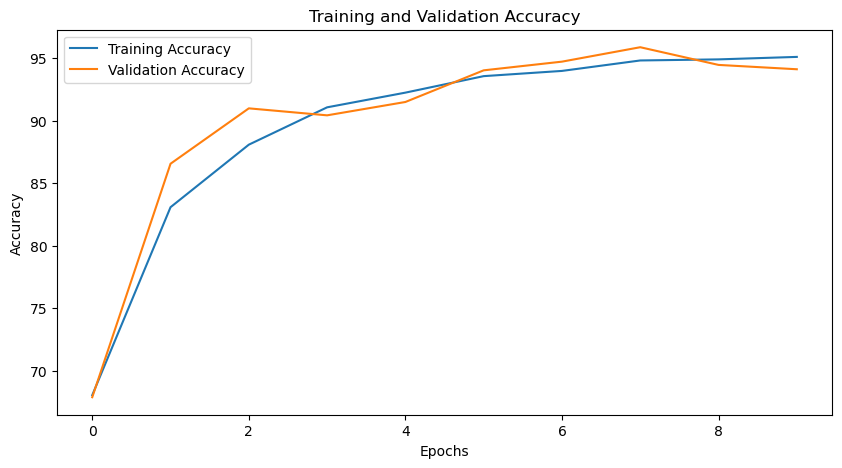

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Part 5: Assuming training actually worked this is where we find loss and test the model, this part is pretty quick normally.

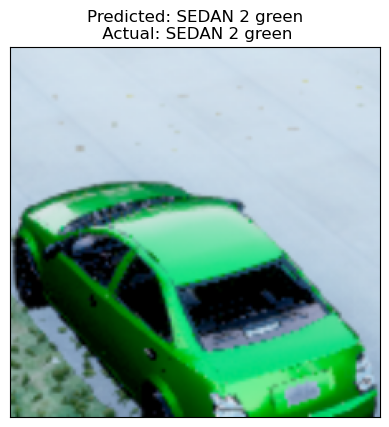

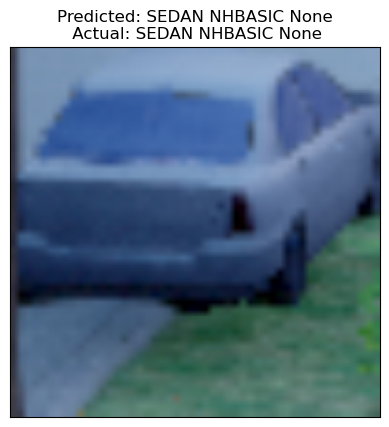

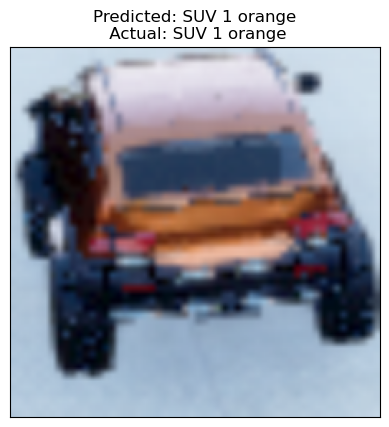

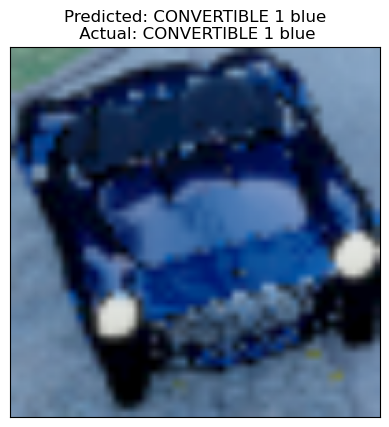

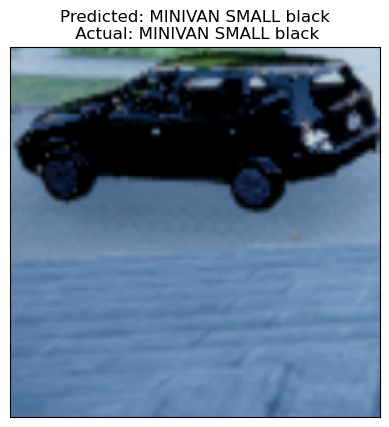

Testing Vehicle Type Accuracy: 93.26%
Testing Vehicle Subtype Accuracy: 90.84%
Testing Vehicle Color Accuracy: 98.47%


In [ ]:
model.load_state_dict(torch.load(os.path.join(current_dir, 'best_model.pth')))
model.eval()  # put model to evaluation mode
# list and variables used for metrics
results = []
flag = True

correct_vehicle_type = 0
correct_vehicle_stype = 0
correct_vehicle_color = 0
total = 0

true_vehicle_type_labels = []
true_vehicle_stype_labels = []
true_vehicle_color_labels = []
pred_vehicle_type_labels = []
pred_vehicle_stype_labels = []
pred_vehicle_color_labels = []

with torch.no_grad(): # begin testing on model
    for images3, labels in dataloaded3:

        images = images3.to(device)
        vehicle_type_labels = labels[0].to(device)
        vehicle_stype_labels = labels[1].to(device)
        vehicle_color_labels = labels[2].to(device)

        outputs = model(images) # send our images to the model

        vehicle_type_preds = outputs[:, :len(vt_encoder.classes_)].argmax(dim=1) # 23 different classes, 0-5 are the Types
        vehicle_stype_preds = outputs[:, len(vt_encoder.classes_):len(vt_encoder.classes_) + len(vst_encoder.classes_)].argmax(dim=1) # 6-13 are the Subtypes
        vehicle_color_preds = outputs[:, len(vt_encoder.classes_) + len(vst_encoder.classes_):].argmax(dim=1) # 14-23 are the colors

        # save our true and predicted labels for metrics
        true_vehicle_type_labels.extend(vehicle_type_labels.cpu().numpy())
        true_vehicle_stype_labels.extend(vehicle_stype_labels.cpu().numpy())
        true_vehicle_color_labels.extend(vehicle_color_labels.cpu().numpy())

        pred_vehicle_type_labels.extend(vehicle_type_preds.cpu().numpy())
        pred_vehicle_stype_labels.extend(vehicle_stype_preds.cpu().numpy())
        pred_vehicle_color_labels.extend(vehicle_color_preds.cpu().numpy())

        # if true labels equals predicted labels, then count that as 1, used for accuracy metric
        correct_vehicle_type += (vehicle_type_preds == vehicle_type_labels).sum().item()
        correct_vehicle_stype += (vehicle_stype_preds == vehicle_stype_labels).sum().item()
        correct_vehicle_color += (vehicle_color_preds == vehicle_color_labels).sum().item()
        total += vehicle_type_labels.size(0)

        # save our results to list for later metrics
        for i in range(images.size(0)):
            vehicle_type = vt_encoder.inverse_transform([vehicle_type_preds[i].item()])[0]
            vehicle_stype = vst_encoder.inverse_transform([vehicle_stype_preds[i].item()])[0]
            vehicle_color = vc_encoder.inverse_transform([vehicle_color_preds[i].item()])[0]
            results.append((vehicle_type, vehicle_stype, vehicle_color))

        if flag is True: # print 5 images with their predicted labels
            for i in range(5):
                # unnormalize image
                img = images3[i] * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                img = torch.clamp(img, 0, 1)  # clamp to [0, 1] range becuase of a warning
                npimg = img.numpy() # convert to numpy for imshow
                plt.imshow(np.transpose(npimg, (1, 2, 0)))
                ttypes = vt_encoder.inverse_transform(vehicle_type_labels.cpu().numpy()) # decode true labels back to strings
                tstypes = vst_encoder.inverse_transform(vehicle_stype_labels.cpu().numpy())
                tcol = vc_encoder.inverse_transform(vehicle_color_labels.cpu().numpy())
                ttypes = ttypes[i]
                tstypes = tstypes[i]
                tcol = tcol[i]
                ptypes = results[i][0]
                pstypes = results[i][1]
                pcol = results[i][2]
                plt.xticks([])
                plt.yticks([])
                plt.title(f'Predicted: {ptypes} {pstypes} {pcol}\n Actual: {ttypes} {tstypes} {tcol}')
                plt.show()
                flag = False

# find the accuracy
vehicle_type_accuracy = correct_vehicle_type / total * 100
vehicle_stype_accuracy = correct_vehicle_stype / total * 100
vehicle_color_accuracy = correct_vehicle_color / total * 100

print(f"Testing Vehicle Type Accuracy: {vehicle_type_accuracy:.2f}%")
print(f"Testing Vehicle Subtype Accuracy: {vehicle_stype_accuracy:.2f}%")
print(f"Testing Vehicle Color Accuracy: {vehicle_color_accuracy:.2f}%")

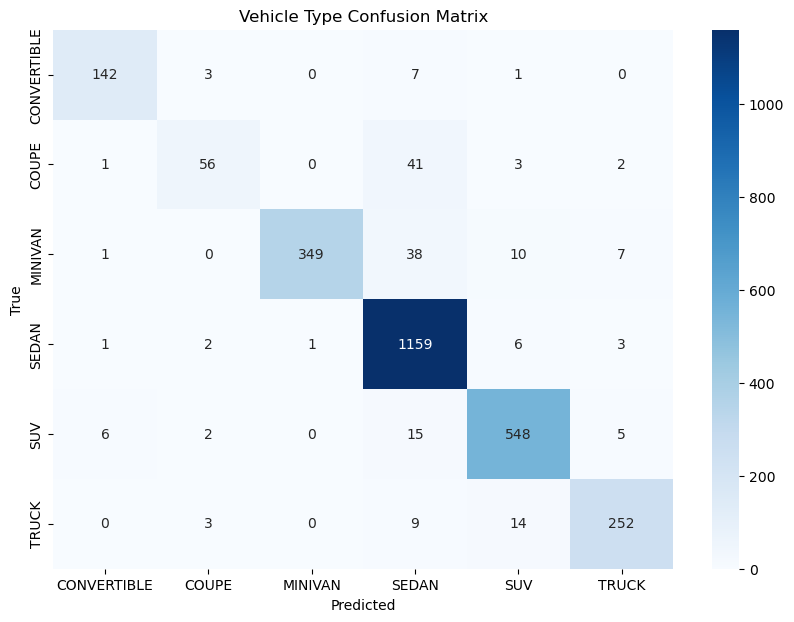

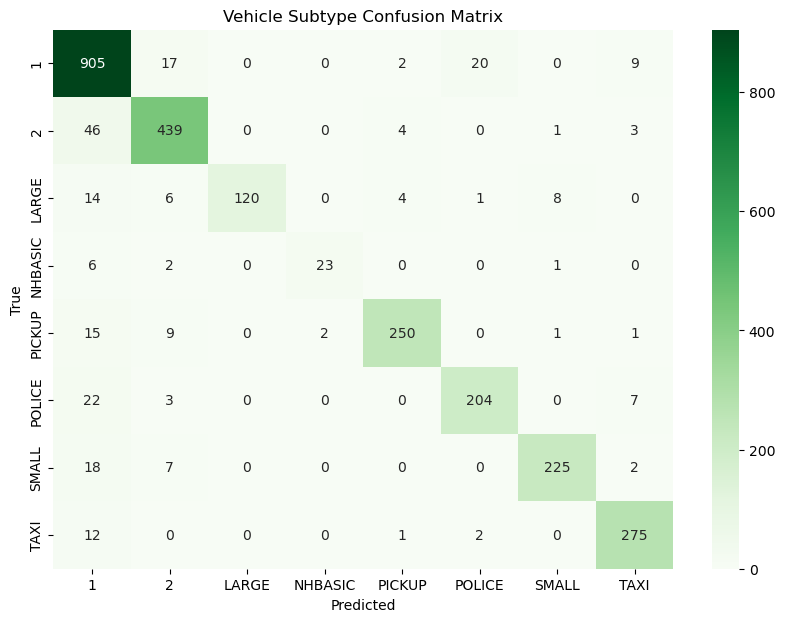

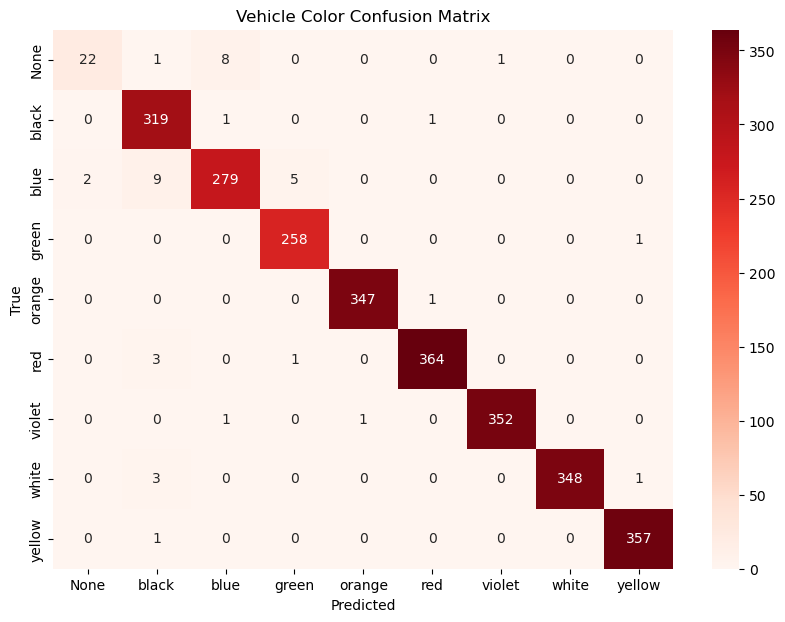

Vehicle Type Classification Report:
              precision    recall  f1-score   support

 CONVERTIBLE       0.94      0.93      0.93       153
       COUPE       0.85      0.54      0.66       103
     MINIVAN       1.00      0.86      0.92       405
       SEDAN       0.91      0.99      0.95      1172
         SUV       0.94      0.95      0.95       576
       TRUCK       0.94      0.91      0.92       278

    accuracy                           0.93      2687
   macro avg       0.93      0.86      0.89      2687
weighted avg       0.93      0.93      0.93      2687

Vehicle Subtype Classification Report:
              precision    recall  f1-score   support

           1       0.87      0.95      0.91       953
           2       0.91      0.89      0.90       493
       LARGE       1.00      0.78      0.88       153
     NHBASIC       0.92      0.72      0.81        32
      PICKUP       0.96      0.90      0.93       278
      POLICE       0.90      0.86      0.88       236
   

In [ ]:
# convert lists to numpy arrays
true_vehicle_type_labels = np.array(true_vehicle_type_labels)
true_vehicle_stype_labels = np.array(true_vehicle_stype_labels)
true_vehicle_color_labels = np.array(true_vehicle_color_labels)

pred_vehicle_type_labels = np.array(pred_vehicle_type_labels)
pred_vehicle_stype_labels = np.array(pred_vehicle_stype_labels)
pred_vehicle_color_labels = np.array(pred_vehicle_color_labels)

# create metrics and confusion matrix for Type feature
conf_matrix_vehicle_type = confusion_matrix(true_vehicle_type_labels, pred_vehicle_type_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_vehicle_type, annot=True, fmt="d", cmap="Blues", xticklabels=vt_encoder.classes_, yticklabels=vt_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Vehicle Type Confusion Matrix')
plt.show()

# create metrics and confusion matrix for Subtype feature
conf_matrix_vehicle_stype = confusion_matrix(true_vehicle_stype_labels, pred_vehicle_stype_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_vehicle_stype, annot=True, fmt="d", cmap="Greens", xticklabels=vst_encoder.classes_, yticklabels=vst_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Vehicle Subtype Confusion Matrix')
plt.show()

# create metrics and confusion matrix for color feature
conf_matrix_vehicle_color = confusion_matrix(true_vehicle_color_labels, pred_vehicle_color_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_vehicle_color, annot=True, fmt="d", cmap="Reds", xticklabels=vc_encoder.classes_, yticklabels=vc_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Vehicle Color Confusion Matrix')
plt.show()

print("Vehicle Type Classification Report:")
print(classification_report(true_vehicle_type_labels, pred_vehicle_type_labels, target_names=vt_encoder.classes_))

print("Vehicle Subtype Classification Report:")
print(classification_report(true_vehicle_stype_labels, pred_vehicle_stype_labels, target_names=vst_encoder.classes_))

print("Vehicle Color Classification Report:")
print(classification_report(true_vehicle_color_labels, pred_vehicle_color_labels, target_names=vc_encoder.classes_))